# CA Wildfire Risk Predictor

In [20]:
# Import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:

df = pd.read_csv("C:\\Users\\Path\\CA_wildfires.csv", low_memory=False)

### Explore Data

+ Figure out how target variable is encoded
+ Check for missing values
+ See data types in the dataframe

In [3]:
df.info()
df.head(2)
value_counts = df['* Damage'].value_counts()
value_counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100230 entries, 0 to 100229
Data columns (total 47 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   _id                                                           100230 non-null  int64  
 1   OBJECTID                                                      100230 non-null  int64  
 2   * Damage                                                      100230 non-null  object 
 3   * Street Number                                               95810 non-null   float64
 4   * Street Name                                                 94744 non-null   object 
 5   * Street Type (e.g. road, drive, lane, etc.)                  87033 non-null   object 
 6   Street Suffix (e.g. apt. 23, blding C)                        44148 non-null   object 
 7   * City                                                  

* Damage
Destroyed (>50%)    53879
No Damage           40895
Affected (1-9%)      3438
Minor (10-25%)       1018
Major (26-50%)        564
Inaccessible          436
Name: count, dtype: int64

In [4]:
missing_percentage = (df.isnull().sum() / len(df)) * 100

# To handle NaN values in the missing percentage (e.g., if a column is entirely NaN)
missing_percentage = missing_percentage.fillna(0)

print("\nPercentage of missing values in each column:")
print(missing_percentage)




Percentage of missing values in each column:
_id                                                              0.000000
OBJECTID                                                         0.000000
* Damage                                                         0.000000
* Street Number                                                  4.409857
* Street Name                                                    5.473411
* Street Type (e.g. road, drive, lane, etc.)                    13.166717
Street Suffix (e.g. apt. 23, blding C)                          55.953307
* City                                                          31.541455
State                                                            0.006984
Zip Code                                                        52.679836
* CAL FIRE Unit                                                  0.000000
County                                                           0.029931
Community                                                       47

## Data Wrangling

+ Encode target variable to use for classifiers
+ Select explanatory features from data set
+ Deal with missing data

In [5]:
# Step 1: Drop columns with excessive missingness (>50%)
threshold = 0.5  # Set threshold for missing values
cols_to_drop = df.columns[df.isnull().mean() > threshold]
df_cleaned = df.drop(columns=cols_to_drop)

# Step 2: Impute missing values
# Numerical columns - fill missing values with the median
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(df_cleaned[numeric_cols].median())

# Categorical columns - fill missing values with the mode
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# Step 3: Drop rows with remaining missing values
df_cleaned = df_cleaned.dropna()

# Step 4: Verify the cleaned dataset
df_cleaned.isnull().sum()

df = df_cleaned




In [6]:
# Create a binary target variable (1 if damage > 50%, 0 otherwise)
df['damage_binary'] = df['* Damage'].apply(lambda x: 1 if x == 'Destroyed (>50%)' else 0)



In [7]:
y = df['damage_binary']

X = df[['* Structure Type',  # Structure Type
        '* Roof Construction',  # Roof construction
        '* Eaves',  # Eaves material
        '* Vent Screen',  # Vent screen
        '* Exterior Siding',  # Exterior siding material
        '* Deck/Porch On Grade',  # Deck/porch on grade
        '* Deck/Porch Elevated',  # Deck/porch elevated
        '* Patio Cover/Carport Attached to Structure',  # Patio cover/carport
        '* Fence Attached to Structure',  # Fence attached to structure
        '* City',  # City (location)
        'County',  # County (location)
        '* CAL FIRE Unit',  # CAL FIRE unit (response area)
        'Latitude',  # Latitude
        'Longitude',  # Longitude
        'Assessed Improved Value (parcel)',  # Assessed value
        'Year Built (parcel)',  # Year built (indicating age of the property)
        'Community',  # Community

       ]]

In [8]:

# Make a copy to ensure the original DataFrame remains unaltered
X_encoded = X.copy()

# Encode categorical columns
categorical_columns = X_encoded.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()

for col in categorical_columns:
    X_encoded[col] = label_encoder.fit_transform(X_encoded[col])

# Step 2: Combine target variable `y` with the encoded features
data_for_corr = pd.concat([X_encoded, y], axis=1)

# Step 3: Calculate the correlation matrix
correlation_matrix = data_for_corr.corr()

# Step 4: Extract correlations with the target variable
correlation_with_target = correlation_matrix['damage_binary'].sort_values(ascending=False)

# Step 5: Display results
print("Correlation Matrix with Target Variable (damage_binary):")
print(correlation_with_target)

Correlation Matrix with Target Variable (damage_binary):
damage_binary                                  1.000000
* Eaves                                        0.280425
Latitude                                       0.233150
* Vent Screen                                  0.194415
Year Built (parcel)                            0.056061
Assessed Improved Value (parcel)              -0.003488
* Structure Type                              -0.006863
* City                                        -0.072466
* CAL FIRE Unit                               -0.081849
Community                                     -0.112845
County                                        -0.150587
* Roof Construction                           -0.189161
* Deck/Porch Elevated                         -0.207286
* Deck/Porch On Grade                         -0.207438
* Fence Attached to Structure                 -0.225159
Longitude                                     -0.243307
* Patio Cover/Carport Attached to Structure   -

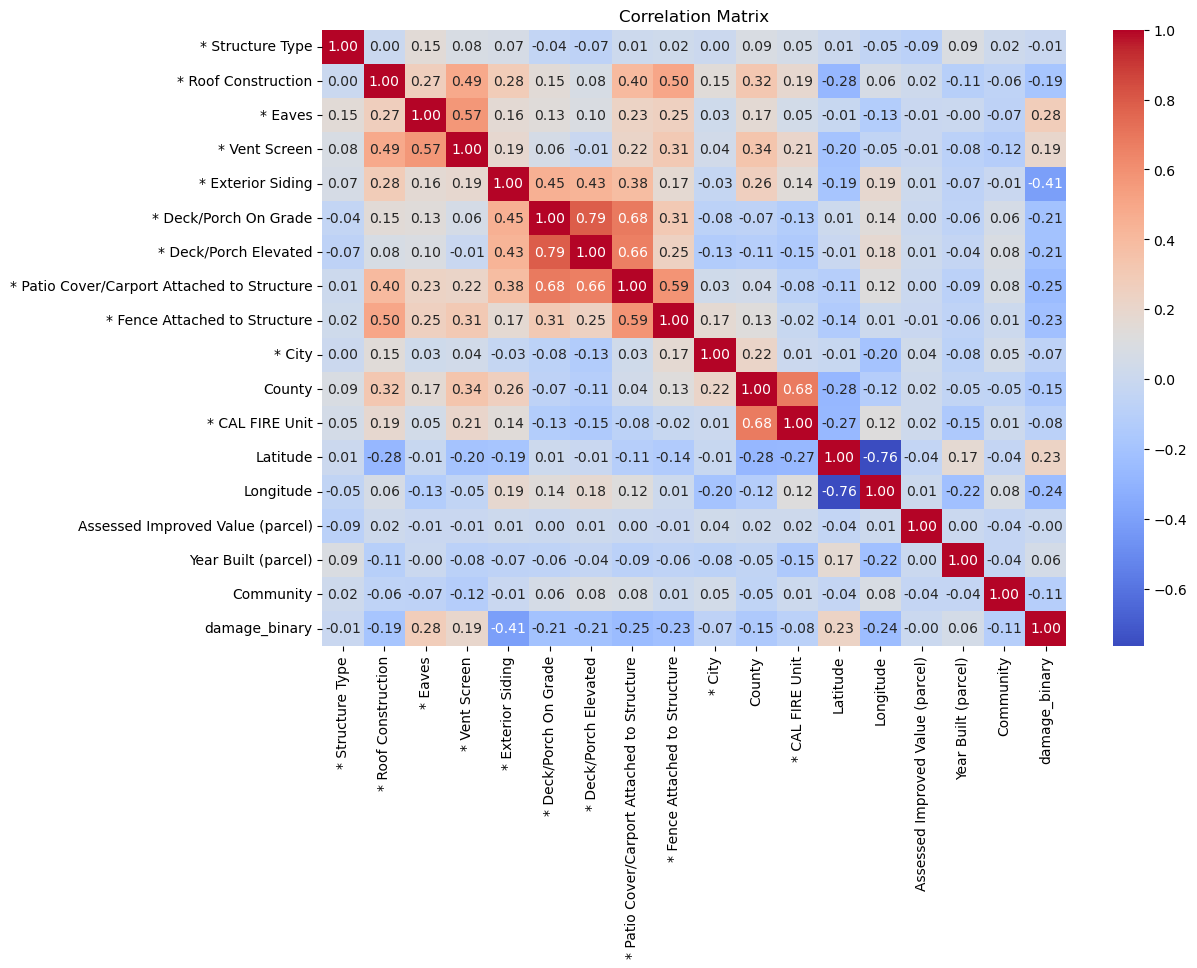

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Model Creation 

+ Train model
+ Hyper parameter tuning
+ Model selection
+ Model assesment

In [10]:
# Find features with high correlation to the target ('Damage_Category')
target_correlation = correlation_matrix['damage_binary'].drop('damage_binary')
high_corr_features = target_correlation[abs(target_correlation) > 0.2].index
print("Highly Correlated Features with Target:", high_corr_features.tolist())

Highly Correlated Features with Target: ['* Eaves', '* Exterior Siding', '* Deck/Porch On Grade', '* Deck/Porch Elevated', '* Patio Cover/Carport Attached to Structure', '* Fence Attached to Structure', 'Latitude', 'Longitude']


### KNN Optimization
+ Find optimal number of neighbors
+ Find optimal number of features
+ (Using 5 fold validation)
+ Note: This code chunk takes a decent amount of time to run, but I had fun re learning about hyper parameterization

In [11]:

# set x and y for model
features = X_encoded
target = y

# Split data to training and testing sets and select size
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,
                                                    random_state=100, stratify=target)
# select standardizer
standardizer = MinMaxScaler()

# Set KNN with classifier
knn = KNeighborsClassifier(n_jobs=-1)

# Add feature selection step to pipeline
pipe = Pipeline([
    ("standardizer", standardizer),
    ("feature_selection", SelectKBest(score_func=f_classif)),  # Feature selection
    ("knn", knn)
])

# Consider 10 different values of K (neighbors) and number of features
search_space = [
    {
        "feature_selection__k": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Number of features
        "knn__n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]       # Number of neighbors
    }
]

# Create search with parameters and set 5-fold cross-validation
classifier = GridSearchCV(pipe, search_space, cv=5, verbose=0).fit(X_train, y_train)

# Calculate best number of features and neighbors
best_k = classifier.best_estimator_.get_params()["feature_selection__k"]
best_n_neighbors = classifier.best_estimator_.get_params()["knn__n_neighbors"]

print(f"Optimal number of features: {best_k}")
print(f"Optimal number of neighbors: {best_n_neighbors}")


Optimal number of features: 5
Optimal number of neighbors: 3


### Selected Optimal Features

In [19]:
# Retrieve the fitted pipeline with the best parameters
best_pipeline = classifier.best_estimator_

# Extract the SelectKBest step from the pipeline
select_kbest = best_pipeline.named_steps["feature_selection"]

# Get the mask of selected features (True for selected features)
selected_mask = select_kbest.get_support()

# Retrieve the names of the selected features
selected_features = features.columns[selected_mask]

print("Features selected for the kNN model:")
print(selected_features.tolist())

Features selected for the kNN model:
['* Eaves', '* Exterior Siding', '* Patio Cover/Carport Attached to Structure', 'Latitude', 'Longitude']


### Optimal KNN Model

In [12]:
# Retrieve the best pipeline from the grid search
best_pipeline = classifier.best_estimator_

# Transform the training and testing data with the optimal features
X_train_selected = best_pipeline.named_steps["feature_selection"].transform(X_train)
X_test_selected = best_pipeline.named_steps["feature_selection"].transform(X_test)

# Initialize a kNN model with the optimal number of neighbors
final_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, n_jobs=-1)

# Fit the final kNN model to the transformed training data
final_knn.fit(X_train_selected, y_train)

# Evaluate the final model on the test set
accuracy = final_knn.score(X_test_selected, y_test)
print(f"Final Model Accuracy: {accuracy}")

C:\Users\roryq\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(
C:\Users\roryq\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(


Final Model Accuracy: 0.9255711862715754


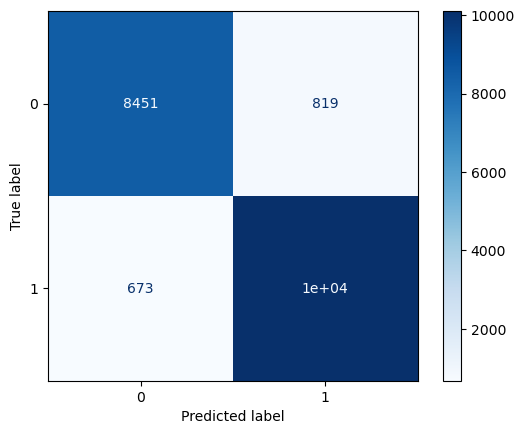

In [17]:

# Predict on the test set
y_pred = final_knn.predict(X_test_selected)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=final_knn.classes_)
disp.plot(cmap="Blues")

In [18]:

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      9270
           1       0.93      0.94      0.93     10776

    accuracy                           0.93     20046
   macro avg       0.93      0.92      0.93     20046
weighted avg       0.93      0.93      0.93     20046



### Naive Bayes Model

+ Ran with scaled and unscaled data
    + Unscaled data preformed slightly better

In [25]:
# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=100, stratify=target
)

# Step 2: Define pipeline for feature selection and Naïve Bayes
pipe_nb = Pipeline([
                    # Scaling (optional for GaussianNB), but matches knn model
    ("feature_selection", SelectKBest(score_func=f_classif)),  # Feature selection
    ("nb", GaussianNB())                              # Naïve Bayes classifier
])

# Step 3: Define the hyperparameter grid
search_space_nb = [
    {
        "feature_selection__k": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Number of features
        "nb__var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]      # Variance smoothing for GaussianNB
    }
]

# Step 4: Perform GridSearchCV to optimize features and hyperparameters
grid_search_nb = GridSearchCV(pipe_nb, search_space_nb, cv=5, verbose=0)
grid_search_nb.fit(X_train, y_train)

# Step 5: Retrieve the best parameters
best_k_nb = grid_search_nb.best_estimator_.get_params()["feature_selection__k"]
best_smoothing = grid_search_nb.best_estimator_.get_params()["nb__var_smoothing"]

print(f"Optimal number of features: {best_k_nb}")
print(f"Optimal variance smoothing: {best_smoothing}")

Optimal number of features: 4
Optimal variance smoothing: 1e-05


In [26]:
# Retrieve the best pipeline
best_pipeline_nb = grid_search_nb.best_estimator_

# Transform the dataset using the best feature selection
X_train_selected = best_pipeline_nb.named_steps["feature_selection"].transform(X_train)
X_test_selected = best_pipeline_nb.named_steps["feature_selection"].transform(X_test)

# Fit the Naïve Bayes model with the optimal configuration
final_nb = GaussianNB(var_smoothing=best_smoothing)
final_nb.fit(X_train_selected, y_train)

# Evaluate the model
accuracy_nb = final_nb.score(X_test_selected, y_test)
print(f"Final Naïve Bayes Model Accuracy: {accuracy_nb}")

Final Naïve Bayes Model Accuracy: 0.798164222288736


In [27]:
# Make predictions on the test set
y_pred_nb = final_nb.predict(X_test_selected)

# Generate classification report
class_report_nb = classification_report(y_test, y_pred_nb, target_names=["Class 0", "Class 1"])
print("Classification Report for Naïve Bayes Model:")
print(class_report_nb)

Classification Report for Naïve Bayes Model:
              precision    recall  f1-score   support

     Class 0       0.75      0.84      0.79      9270
     Class 1       0.85      0.76      0.80     10776

    accuracy                           0.80     20046
   macro avg       0.80      0.80      0.80     20046
weighted avg       0.80      0.80      0.80     20046



#### Optimal Features

In [30]:
# Retrieve the best pipeline from GridSearchCV
best_pipeline_nb = best_pipeline_nb = grid_search_nb.best_estimator_

# Extract the SelectKBest step from the pipeline
select_kbest_no_std = best_pipeline_nb.named_steps["feature_selection"]

# Get the mask of selected features (True for selected features)
selected_mask_no_std = select_kbest.get_support()

# Retrieve the names of the selected features
selected_features_no_std = features.columns[selected_mask_no_std]

print("Features selected for Gaussian Naïve Bayes (without standardization):")
print(selected_features_no_std.tolist())

Features selected for Gaussian Naïve Bayes (without standardization):
['* Eaves', '* Exterior Siding', '* Patio Cover/Carport Attached to Structure', 'Latitude', 'Longitude']


## Model Comparison

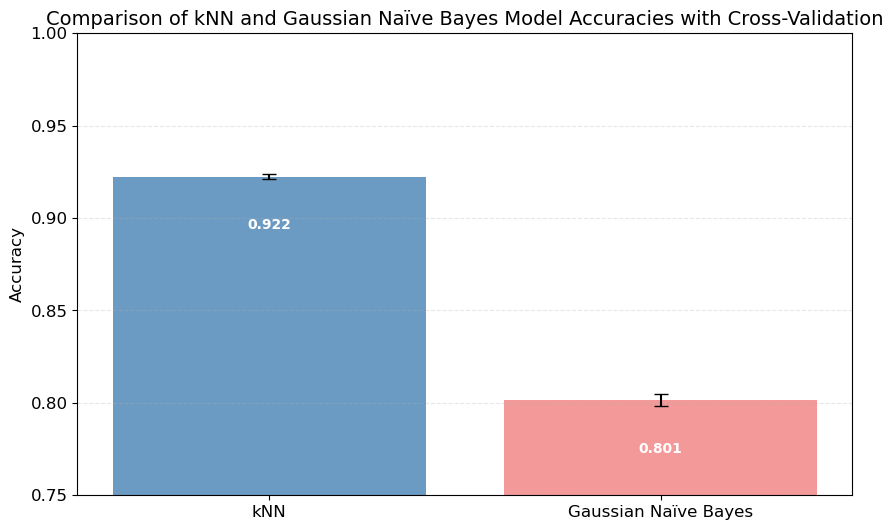

In [42]:
# Extracting cross-validation results from GridSearchCV for kNN and Naive Bayes

# For kNN
cv_results_knn = classifier.cv_results_
mean_knn = cv_results_knn['mean_test_score'][classifier.best_index_]
std_knn = cv_results_knn['std_test_score'][classifier.best_index_]

# For Naive Bayes
cv_results_nb = grid_search_nb.cv_results_
mean_nb = cv_results_nb['mean_test_score'][grid_search_nb.best_index_]
std_nb = cv_results_nb['std_test_score'][grid_search_nb.best_index_]

# Model names and their accuracies
model_names = ["kNN", "Gaussian Naïve Bayes"]
means = [mean_knn, mean_nb]
stds = [std_knn, std_nb]

# Create the bar chart with error bars
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, means, yerr=stds, color=['steelblue', 'lightcoral'], alpha=0.8, capsize=5)

# Add mean accuracy labels on top of the bars
for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.03, 
             f"{mean:.3f}", ha='center', va='bottom', fontsize=10, color='white', fontweight='bold')

# Customize the chart
plt.title("Comparison of kNN and Gaussian Naïve Bayes Model Accuracies with Cross-Validation", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.75, 1.0)  # Adjust range for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
